### Nandini `MDS202335`
### Aritra `MCS202304`

# Import necessary modules

In [ ]:
import pandas as pd
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from prettytable import PrettyTable

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
DATA_PATH = "/kaggle/input/sms-spam-collection-dataset"

# Load and Preprocess Data

1. **Load Dataset**: The `spam.csv` file is loaded from the specified `DATA_PATH` using `latin1` encoding to handle special characters.
2. **Drop Unnecessary Columns**: Columns `"Unnamed: 2"`, `"Unnamed: 3"`, and `"Unnamed: 4"` are removed as they contain no useful information for the analysis.
3. **Rename Columns**: The column `"v1"` is renamed to `"category"`, representing the type of message (e.g., spam or ham), and `"v2"` to `"message"`, representing the text of the message.
4. **Preview Data**: The first 10 rows of the processed data are displayed for inspection.


In [4]:
data = pd.read_csv(os.path.join(DATA_PATH, "spam.csv"), encoding='latin1')

data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
data = data.rename(columns={"v1": "category", "v2": "message"})

data.head(10)

,category,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


# Visualize Category Distribution (Spam vs Ham)

**Count and Plot Categories**: The distribution of messages across categories (`Ham` and `Spam`) is visualized using a pie chart.

This plot provides an intuitive view of the class distribution within the dataset, useful for understanding the data balance.


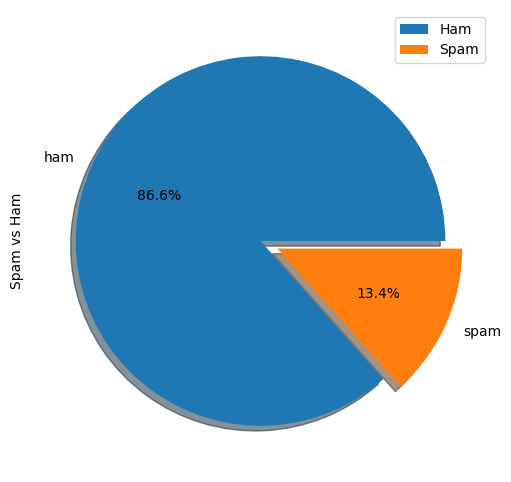

In [5]:
data["category"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

## Stratified sampling
A lot of messages are actually not spam. About 86% of our dataset consists of normal messages.While we split our data set into train and test or when we use cross validation, we will have to use stratified sampling, otherwise we have a chance of our training model being skewed towards normal messages. If the sample we choose to train our model consists majorly of normal messages, it may end up predicting everything as ham and we might not be able to figure this out since most of the messages we get are actually ham and will have a pretty good accuracy (around 86%).

In [5]:
X = data['message']
y = data['category']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split Dataset into Training and Testing Sets

1. **Split Data**: `train_test_split` divides the dataset into training and testing sets with an 80-20 split.
   - `X`: Features (input data).
   - `y`: Target labels (output categories).
2. **Stratified Sampling**: `stratify=y` ensures that the training and testing sets maintain the same class distribution as the original dataset, preserving balance between categories.
This setup prepares the data for training and evaluating the model while maintaining consistent class proportions.


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=41)

# Vectorize Text Data using TF-IDF
By using TF-IDF, this approach captures the relative importance of words in messages, improving model performance on text data.


In [9]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

# SMS Dataset Class

In [10]:
class SMSDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# Create Datasets and Data Loaders for Model Training

1. **Initialize Datasets**:
   - `train_dataset`: An instance of `SMSDataset` created using `X_train_vec` and `y_train`.
   - `test_dataset`: An instance of `SMSDataset` created using `X_test_vec` and `y_test`.


2. **Define Data Loaders**:
   - `train_loader`: A `DataLoader` for the training dataset with a batch size of 32.
   - `test_loader`: A `DataLoader` for the testing dataset with a batch size of 32.


In [11]:
train_dataset = SMSDataset(X_train_vec, y_train)
test_dataset = SMSDataset(X_test_vec, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# RNN Model Class Definition

This class defines a simple Recurrent Neural Network (RNN) model for sequence classification.

**Initialization**:
   - `input_size`:  The TF-IDF vector size.
   - `hidden_size`: Number of features in the RNN's hidden state.
   - `output_size`: Number of output classes (2 for spam and ham classification).
  


In [12]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# LSTM Model Class Definition

This class defines a Long Short-Term Memory (LSTM) model for sequence classification.

**Initialization**:
   - `input_size`:  the TF-IDF vector size.
   - `hidden_size`: Number of features in the LSTM's hidden state.
   - `output_size`: Number of output classes (2 for spam and ham classification).

The LSTM structure allows the model to capture long-term dependencies in the sequence data, which can enhance performance on tasks involving sequential patterns.


In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# Get Number of Parameters in a Model

- This function calculates the total number of parameters in a given PyTorch model.

- It is useful for comparing model complexity across different architectures.


In [14]:
def get_n_params(model):
    """
    returns the number of parameters of a model
    """
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

# Model Initialization and Summary

1. **Loss Function and Optimizers**: 
   - Defines a weighted cross-entropy loss function to handle class imbalance.
   - Sets up Adam optimizers for both models.
  
From the `summary table`, we can see that both the `LSTM` and the `RNN` model have about same number of parameters.


In [15]:
input_size = X_train_vec.shape[1]
hidden_size_rnn = 128
hidden_size_lstm = 32
output_size = len(label_encoder.classes_)
num_epochs = 100
learning_rate = 0.001

rnn_model = RNNModel(input_size, hidden_size_rnn, output_size).to(device)
lstm_model = LSTMModel(input_size, hidden_size_lstm, output_size).to(device)

class_weights = torch.tensor([0.14, 0.86], device=device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=learning_rate)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)

rnn_params = get_n_params(rnn_model)
lstm_params = get_n_params(lstm_model)

table = PrettyTable()
table.field_names = ["Model", "Number of Parameters"]
table.add_row(["RNN Model", rnn_params])
table.add_row(["LSTM Model", lstm_params])

print(table)

+------------+----------------------+
|   Model    | Number of Parameters |
+------------+----------------------+
| RNN Model  |       1012994        |
| LSTM Model |       1000514        |
+------------+----------------------+


# Model Training Function

The `train_model` function trains a PyTorch model over a specified number of epochs using a data loader and an optimizer.

- `rnn_losses`: Stores the training losses for the RNN model.
- `lstm_losses`: Stores the training losses for the LSTM model.


In [16]:
def train_model(model, data_loader, optimizer, num_epochs):
    """
    train the model for num_epochs
    """
    model.train()
    epoch_losses = []
    for epoch in tqdm(range(num_epochs),  desc=f"Training {model.__class__.__name__} for {num_epochs} epochs"):
        total_loss = 0
        for texts, labels in data_loader:
            texts, labels = texts.to(device), labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(data_loader)
        epoch_losses.append(avg_loss)
        
        # Print n intrvals
        if (epoch-19) % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
            
    return epoch_losses

# Train the RNN and the LSTM model

rnn_losses = train_model(rnn_model, train_loader, rnn_optimizer, num_epochs)
lstm_losses = train_model(lstm_model, train_loader, lstm_optimizer, num_epochs)

Training RNNModel for 100 epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [20/100], Loss: 0.0003
Epoch [40/100], Loss: 0.0000
Epoch [60/100], Loss: 0.0000
Epoch [80/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000


Training LSTMModel for 100 epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [20/100], Loss: 0.0011
Epoch [40/100], Loss: 0.0001
Epoch [60/100], Loss: 0.0000
Epoch [80/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000


# Plotting Loss vs. Epochs for RNN and LSTM Models


Plot loss vs epochs for both the models:



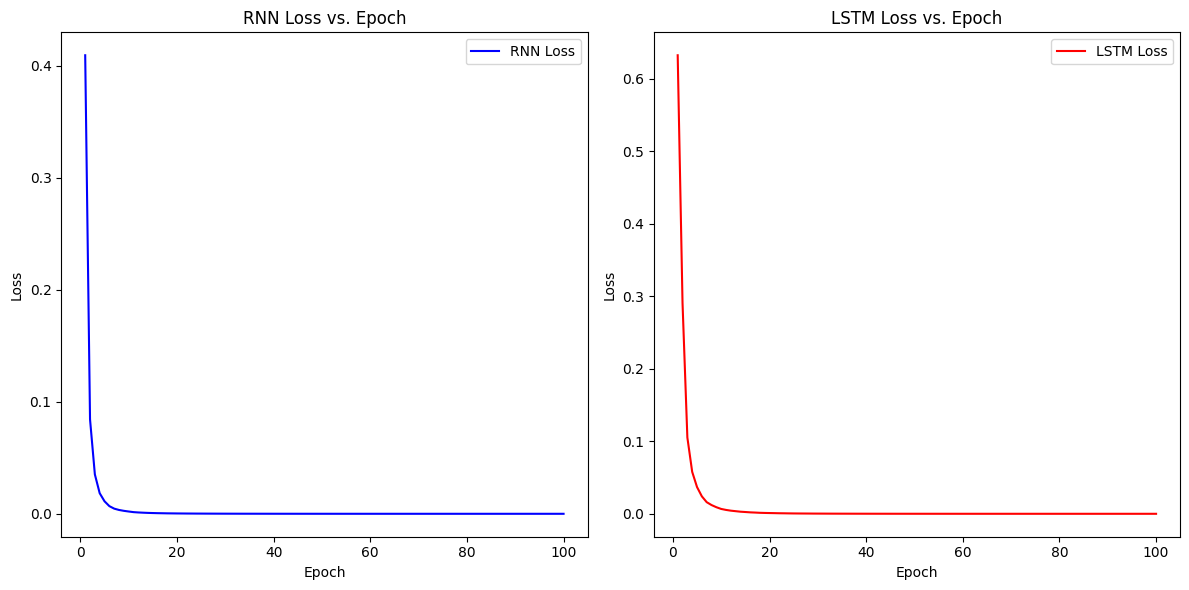

In [31]:
print("\nPlot loss vs epochs for both the models:\n")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), rnn_losses, label='RNN Loss', color='b')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("RNN Loss vs. Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), lstm_losses, label='LSTM Loss', color='r')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LSTM Loss vs. Epoch")
plt.legend()

plt.tight_layout()
plt.show()

# Model Accuracy Evaluation Functions

The code below defines two functions to evaluate the accuracy of a given model and then computes the accuracy for both the RNN and LSTM models considering class imbalance in the dataset.

## Functions

### 1. `get_accuracy(model, data_loader)`
- Computes the standard accuracy of the model on the provided data loader.
- Returns the accuracy as a ratio of correct predictions to total samples.

### 2. `get_weighted_accuracy(model, data_loader)`
- Computes weighted accuracy to account for class imbalance.
- Similar to `get_accuracy`, but applies weights:
  - Assigns higher weights (86 for spam, 14 for ham) based on the true label when updating the `correct` and `total` counts.
- Returns the weighted accuracy.
 


In [32]:
def get_accuracy(model, data_loader):
    """
    returns the accuracy score comparing the model output and the predicted output
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for texts, labels in data_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            _, predicted = torch.max(outputs.data, 1)
            for idx in range(len(predicted)):
                if labels[idx] == 1:
                    total += 1
                    correct += (predicted[idx] == labels[idx])*1
                else:
                    total += 1
                    correct += (predicted[idx] == labels[idx])*1
    return correct / total

def get_weighted_accuracy(model, data_loader):
    """
    returns the wighted accuracy where the minority spam class gets higher score
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for texts, labels in data_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            _, predicted = torch.max(outputs.data, 1)
            for idx in range(len(predicted)):
                if labels[idx] == 1:
                    total += 86
                    correct += (predicted[idx] == labels[idx])*86
                else:
                    total += 14
                    correct += (predicted[idx] == labels[idx])*14
    return correct / total

# Evaluate both models
rnn_accuracy = get_accuracy(rnn_model, test_loader)
lstm_accuracy = get_accuracy(lstm_model, test_loader)

rnn_weighted_accuracy = get_weighted_accuracy(rnn_model, test_loader)
lstm_weighted_accuracy = get_weighted_accuracy(lstm_model, test_loader)

print("\n")
print(f'RNN Test Accuracy: {rnn_accuracy * 100:.2f}%')
print(f'LSTM Test Accuracy: {lstm_accuracy * 100:.2f}%')

print("\n")
print(f'RNN Test Weighted Accuracy: {rnn_weighted_accuracy * 100:.2f}%')
print(f'LSTM Test Weighted Accuracy: {lstm_weighted_accuracy * 100:.2f}%')



RNN Test Accuracy: 98.92%
LSTM Test Accuracy: 98.83%


RNN Test Weighted Accuracy: 96.63%
LSTM Test Weighted Accuracy: 96.85%


# Combined Predictions Display for RNN and LSTM Models

The `show_combined_examples` function displays the predictions of both RNN and LSTM models on a test dataset alongside the actual labels.

In [33]:
def show_combined_examples(rnn_model, lstm_model, data_loader):
    
    marker = 1
    
    rnn_model.eval()
    lstm_model.eval()
    
    with torch.no_grad():
        table = PrettyTable()
        table.field_names = ["Text", "Actual Label", "RNN Predicted", "LSTM Predicted"]

        different_predictions = []

        for texts, labels in data_loader:
            texts, labels = texts.to(device), labels.to(device)

            rnn_outputs = rnn_model(texts)
            _, rnn_predicted = torch.max(rnn_outputs.data, 1)

            lstm_outputs = lstm_model(texts)
            _, lstm_predicted = torch.max(lstm_outputs.data, 1)
            
            if marker == 1:
                marker = 0
                for i in range(5):
                    text = vectorizer.inverse_transform(texts[i].cpu().numpy().reshape(1, -1))[0]
                    actual_label = label_encoder.inverse_transform([labels[i].item()])[0]
                    rnn_predicted_label = label_encoder.inverse_transform([rnn_predicted[i].item()])[0]
                    lstm_predicted_label = label_encoder.inverse_transform([lstm_predicted[i].item()])[0]
                    
                    table.add_row([
                        " ".join(text),
                        actual_label,
                        rnn_predicted_label,
                        lstm_predicted_label
                    ])
                    

            for i in range(texts.size(0)):  # Iterate through all texts in the batch
                text = vectorizer.inverse_transform(texts[i].cpu().numpy().reshape(1, -1))[0]
                actual_label = label_encoder.inverse_transform([labels[i].item()])[0]
                rnn_predicted_label = label_encoder.inverse_transform([rnn_predicted[i].item()])[0]
                lstm_predicted_label = label_encoder.inverse_transform([lstm_predicted[i].item()])[0]

                # Check if the predictions are different
                if rnn_predicted[i] != lstm_predicted[i]:
                    different_predictions.append([
                        " ".join(text),
                        actual_label,
                        rnn_predicted_label,
                        lstm_predicted_label
                    ])
                
                
                if len(different_predictions) >= 10:
                    break
            if len(different_predictions) >= 10:
                break

        for row in different_predictions:
            table.add_row(row)

    print(table)

print("Combined Results for RNN and LSTM")
show_combined_examples(rnn_model, lstm_model, test_loader)


Combined Results for RNN and LSTM
+-------------------------------------------------------------------+--------------+---------------+----------------+
|                                Text                               | Actual Label | RNN Predicted | LSTM Predicted |
+-------------------------------------------------------------------+--------------+---------------+----------------+
| 500 80488 account and credit free just ll msgs ok text to we your |     spam     |      spam     |      spam      |
|               booked hey lessons liao on sun the ve               |     ham      |      ham      |      ham       |
|                  from know snowman songs the yes                  |     ham      |      ham      |      ham       |
|                      convey him my regards to                     |     ham      |      ham      |      ham       |
|                     many sweets there were yes                    |     ham      |      ham      |      ham       |
|  accordingly and jus

### Conclusion:

From the `accuracy` and the `weighted accuracy` measure, we can conclude that:

- `RNN` generalizes better compared to `LSTM`, this might be due to the fact that message sequences are not too long, and so, don't require `Long memory` of LSTM.
- However, `LSTM` seems to be more robust and useful, because most of the mistakes it did were predicting `ham` as `spam` (which is less malignant). It even has a higher `weighted accuracy`.